## investigation of convergence

In [24]:
# peak_convergence.py
import os, json
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from lattice import Lattice
from monte_carlo import MonteCarlo

def chi_peak_refined(T, chi):
    s = UnivariateSpline(T, chi, s=0, k=3)
    TT = np.linspace(T.min(), T.max(), 4001)
    YY = s(TT)
    i  = int(np.argmax(YY))
    return float(TT[i]), float(YY[i])

def collect_peak_vs_L(
    sizes=np.arange(20,44,4),#np.logspace(np.log10(10), np.log10(200), num=10, dtype=int),
    delta=0.05, kf=0.5, J0=-1.0,
    T_grid=np.linspace(5.0, 165.0, 161),
    warmup=500, steps=5_000,
    method="wolff",
    out_json="peak_convergence_kf05_2.json"
):
    results = {
        "delta": float(delta),
        "kf": float(kf),
        "J0": float(J0),
        "warmup": int(warmup),
        "steps": int(steps),
        "method": method,
        "entries": []
    }

    for L in sizes:
        lat = Lattice(rows=L, cols=L, doping=delta, kf=kf, J0=J0)  
        mc  = MonteCarlo(lat, progress=False)

        E_mean, Mabs_mean, Chi_mean = [], [], []
        for T in T_grid:
            mc.acc.energy.clear()
            mc.acc.magnetization.clear()
            mc.acc.susceptibility.clear()

            mc.run_loop(warmup_steps=warmup, steps=steps, T=float(T), method=method)

            E_mean.append(np.mean(mc.acc.energy))
            Mabs_mean.append(np.mean(np.abs(mc.acc.magnetization)))
            Chi_mean.append(np.mean(mc.acc.susceptibility))

        E_mean  = np.asarray(E_mean, float)
        Mabs_mean = np.asarray(Mabs_mean, float)
        Chi_mean  = np.asarray(Chi_mean, float)

        T_peak, chi_max = chi_peak_refined(T_grid, Chi_mean)

        
        i_close = int(np.argmin(np.abs(T_grid - T_peak)))
        chi_series = np.asarray(mc.acc.susceptibility, float) 
        mc.acc.susceptibility.clear()
        mc.run_loop(warmup_steps=0, steps=steps, T=float(T_grid[i_close]), method=method)
        chi_series = np.asarray(mc.acc.susceptibility, float)

        acf = mc.acc.autocorr_fft(chi_series)                  
        tau = mc.acc.tau_int_from_acf(acf)                     
        chi_err = mc.acc.calculate_error(chi_series, tau)      

        entry = {
            "L": int(L),
            "N": int(lat.N),
            "T_peak": T_peak,
            "chi_max": chi_max,
            "chi_err_at_peak": float(chi_err),
            "acceptance_rate_lastT": float(getattr(mc, "acceptance_rate", np.nan)),
            "T_grid": list(map(float, T_grid)),
            "Chi_T": list(map(float, Chi_mean)),
            "Mabs_T": list(map(float, Mabs_mean)),
            "E_T": list(map(float, E_mean))
        }
        results["entries"].append(entry)
        print(f"L={L:>3d} | N={lat.N:>4d} | T_peak≈{T_peak:5.2f} | χ_max≈{chi_max:7.3f} ± {chi_err:6.3f}")

    with open(out_json, "w") as f:
        json.dump(results, f, indent=2)
    return results


In [25]:
np.linspace(5.0, 65.0, 61)

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65.])

In [27]:
%%time
collect_peak_vs_L()

/home/lisa/Desktop/proj/monte-carlo-PtSe2/lattice.py:69: RuntimeWarning: invalid value encountered in multiply
  j1(self.kf * distances) * y1(self.kf * distances)


L= 20 | N=  20 | T_peak≈ 5.00 | χ_max≈  3.786 ±  0.015
L= 24 | N=  33 | T_peak≈ 5.00 | χ_max≈  6.379 ±  0.028
L= 28 | N=  49 | T_peak≈ 5.00 | χ_max≈  9.563 ±  0.026
L= 32 | N=  61 | T_peak≈ 5.00 | χ_max≈ 11.981 ±  0.040
L= 36 | N=  77 | T_peak≈ 5.00 | χ_max≈ 15.161 ±  0.034
L= 40 | N=  86 | T_peak≈ 5.00 | χ_max≈ 17.020 ±  0.031
CPU times: user 5min 10s, sys: 578 ms, total: 5min 11s
Wall time: 5min 11s


{'delta': 0.05,
 'kf': 0.5,
 'J0': -1.0,
 'warmup': 500,
 'steps': 5000,
 'method': 'wolff',
 'entries': [{'L': 20,
   'N': 20,
   'T_peak': 5.0,
   'chi_max': 3.7864880000000007,
   'chi_err_at_peak': 0.014611106398971445,
   'acceptance_rate_lastT': 0.0,
   'T_grid': [5.0,
    6.0,
    7.0,
    8.0,
    9.0,
    10.0,
    11.0,
    12.0,
    13.0,
    14.0,
    15.0,
    16.0,
    17.0,
    18.0,
    19.0,
    20.0,
    21.0,
    22.0,
    23.0,
    24.0,
    25.0,
    26.0,
    27.0,
    28.0,
    29.0,
    30.0,
    31.0,
    32.0,
    33.0,
    34.0,
    35.0,
    36.0,
    37.0,
    38.0,
    39.0,
    40.0,
    41.0,
    42.0,
    43.0,
    44.0,
    45.0,
    46.0,
    47.0,
    48.0,
    49.0,
    50.0,
    51.0,
    52.0,
    53.0,
    54.0,
    55.0,
    56.0,
    57.0,
    58.0,
    59.0,
    60.0,
    61.0,
    62.0,
    63.0,
    64.0,
    65.0,
    66.0,
    67.0,
    68.0,
    69.0,
    70.0,
    71.0,
    72.0,
    73.0,
    74.0,
    75.0,
    76.0,
    77.0,
    78.0

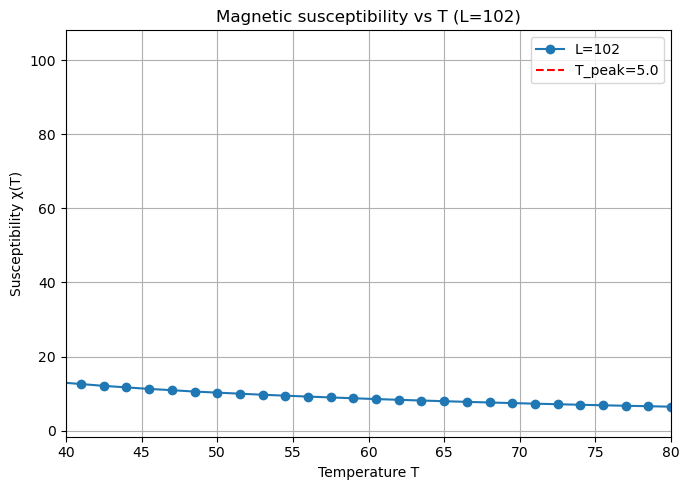

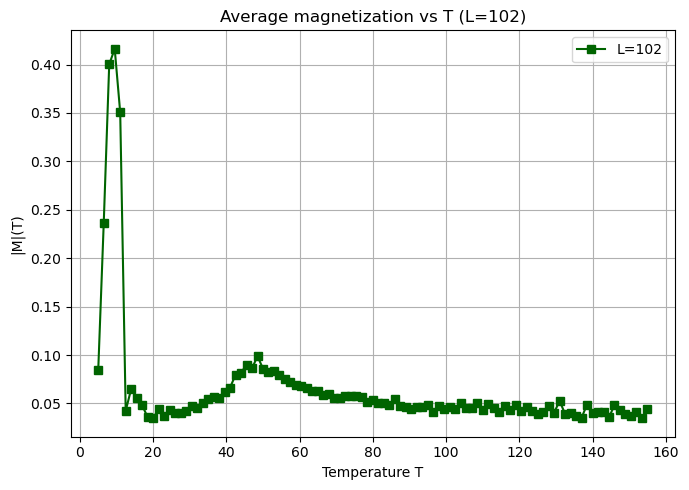

In [17]:
import json
import matplotlib.pyplot as plt

# === Загрузка файла ===
with open("peak_convergence_102.json") as f:  # замени на имя своего файла
    data = json.load(f)

entry = data["entries"][0]   # один размер L

T = entry["T_grid"]
Chi = entry["Chi_T"]
Mabs = entry["Mabs_T"]

L = entry["L"]
T_peak = entry["T_peak"]
chi_max = entry["chi_max"]

# === Susceptibility ===
plt.figure(figsize=(7,5))
plt.plot(T, Chi, 'o-', lw=1.5, label=f"L={L}")
plt.axvline(T_peak, color='r', ls='--', label=f"T_peak={T_peak}")
plt.xlabel("Temperature T")
plt.ylabel("Susceptibility χ(T)")
plt.title(f"Magnetic susceptibility vs T (L={L})")
plt.legend()
plt.grid(True)
plt.xlim(40,80)
# plt.ylim(0,5)
plt.tight_layout()
plt.show()

# === Magnetization ===
plt.figure(figsize=(7,5))
plt.plot(T, Mabs, 's-', lw=1.5, color='darkgreen', label=f"L={L}")
plt.xlabel("Temperature T")
plt.ylabel("|M|(T)")
plt.title(f"Average magnetization vs T (L={L})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_12054/337802780.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(entries))


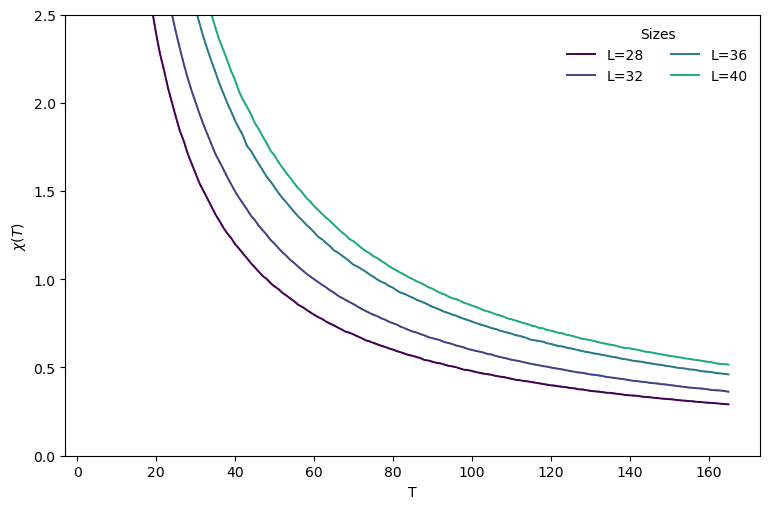

L= 28  T_peak_spline=5.000000   chi_max_spline=9.562580
L= 32  T_peak_spline=5.000000   chi_max_spline=11.980695
L= 36  T_peak_spline=5.000000   chi_max_spline=15.161405
L= 40  T_peak_spline=5.000000   chi_max_spline=17.019578


In [29]:
import json, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import UnivariateSpline

INFILE = "peak_convergence_kf05_2.json"

def refined_peak_spline(T, chi, s=0.0, k=3, ngrid=4001):
    """
    Уточнение пика χ(T) сплайном (по умолчанию: кубический, без сглаживания).
    Возвращает (T_peak, chi_max, (TT, YY)) где (TT,YY) — сглаженная кривая.
    """
    T = np.asarray(T, float); chi = np.asarray(chi, float)
    m = np.isfinite(T) & np.isfinite(chi)
    T, chi = T[m], chi[m]
    i = np.argsort(T); T, chi = T[i], chi[i]
    # если точек мало — fallback: дискретный максимум
    if len(T) < k+1:
        j = int(np.argmax(chi))
        return float(T[j]), float(chi[j]), (T, chi)
    spl = UnivariateSpline(T, chi, s=s, k=k)
    TT  = np.linspace(T.min(), T.max(), ngrid)
    YY  = spl(TT)
    j   = int(np.argmax(YY))
    return float(TT[j]), float(YY[j]), (TT, YY)

# --- загрузка
with open(INFILE, "r") as f:
    data = json.load(f)
entries = sorted(data["entries"], key=lambda e: e["L"])

# --- построение
plt.figure(figsize=(7.8, 5.2))
cmap = cm.get_cmap("viridis", len(entries))
summary = []

for i, e in enumerate(entries[2:]):
    L   = e["L"]
    T   = np.array(e["T_grid"], float)
    chi = np.array(e["Chi_T"],  float)

    # s=0 — интерполяция; если шумно, попробуй s = 1e-4 * sum((chi - chi.mean())**2)
    Tpk, chimax, (TT, YY) = refined_peak_spline(T, chi, s=0.0, k=3, ngrid=2001)
    summary.append((L, Tpk, chimax))

    color = cmap(i)
    plt.plot(T, chi, '-', lw=1.4, color=color, label=f"L={L}")
    plt.plot(TT, YY, '--', lw=1.0, color=color, alpha=0.9)   # сплайн (штрихом)
    plt.plot([Tpk], [chimax], 'o', ms=5.2, color=color)      # пик
    # plt.annotate(f"T*={Tpk:.4g}", xy=(Tpk, chimax),
    #              xytext=(4,6), textcoords="offset points",
    #              fontsize=8, color=color)

plt.xlabel("T"); plt.ylabel(r"$\chi(T)$")
plt.legend(title="Sizes", frameon=False, ncol=2)
# plt.xlim(10,150)
plt.ylim(0,2.5)
plt.tight_layout(); plt.show()

# --- сводка
for L, Tpk, chimax in summary:
    print(f"L={L:>3}  T_peak_spline={Tpk:.6f}   chi_max_spline={chimax:.6f}")


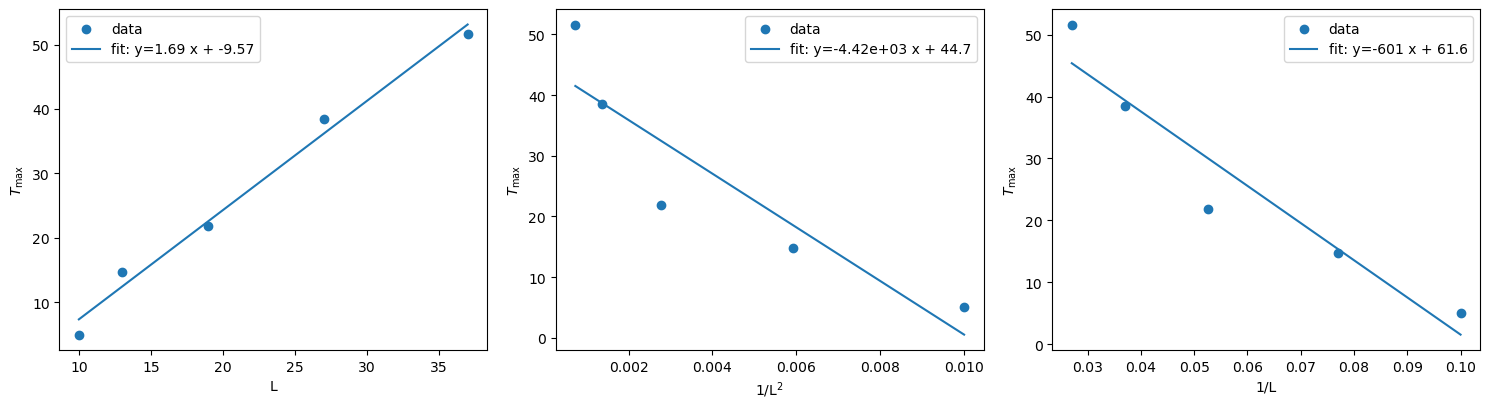

Linear fits (slope, intercept)  — intercept ~ Tc (для 1/L и 1/L^2):
Tmax vs 1/L   : slope=-600.661, intercept=61.6132
Tmax vs 1/L^2 : slope=-4423.06, intercept=44.7307
Tmax vs L     : slope=1.69405, intercept=-9.57379
Fit status per L (True=logG, False=spline): {np.int64(10): True, np.int64(13): True, np.int64(19): True, np.int64(27): True, np.int64(37): True}


In [ ]:
import json, numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

INFILE = "peak_convergence_log.json"

# --- log-Gaussian model
def log_gauss(T, A, mu, sigma, bg):
    T = np.asarray(T, float)
    return bg + (A/(T * sigma * np.sqrt(2*np.pi))) * np.exp(- (np.log(T) - mu)**2 / (2*sigma**2))

def refined_peak_log_gauss(T, chi, use_window=True, window_pts=21, frac_of_max=0.55):
    """Возврат: T_peak, chi_peak, ok_flag"""
    T = np.asarray(T, float); chi = np.asarray(chi, float)
    m = np.isfinite(T) & np.isfinite(chi) & (T > 0)
    T, chi = T[m], chi[m]
    if len(T) < 5:
        j = int(np.argmax(chi)); return float(T[j]), float(chi[j]), False
    i = np.argsort(T); T, chi = T[i], chi[i]

    if use_window:
        j0 = int(np.argmax(chi))
        if window_pts is not None:
            i1 = max(0, j0 - window_pts//2); i2 = min(len(T), j0 + window_pts//2 + 1)
            Tw, cw = T[i1:i2], chi[i1:i2]
        else:
            thr = chi[j0]*frac_of_max
            idx = np.where(chi >= thr)[0]; i1, i2 = idx.min(), idx.max()+1
            Tw, cw = T[i1:i2], chi[i1:i2]
    else:
        Tw, cw = T, chi

    if len(Tw) < 5:
        j = int(np.argmax(chi)); return float(T[j]), float(chi[j]), False

    jmax = int(np.argmax(cw))
    Tpk0 = float(Tw[jmax])
    bg0  = float(np.percentile(cw, 10))
    sigma0 = 0.25
    mu0 = np.log(max(Tpk0, 1e-9))
    A0 = max((cw[jmax]-bg0) * Tpk0 * sigma0 * np.sqrt(2*np.pi) * np.exp(+sigma0**2/2), 1e-12)
    p0 = [A0, mu0, sigma0, bg0]
    lo = [0.0, np.log(Tw.min())-1.0, 0.05, 0.0]
    hi = [np.inf, np.log(Tw.max())+1.0, 2.0, np.max(cw)*1.5]

    try:
        popt, _ = curve_fit(log_gauss, Tw, cw, p0=p0, bounds=(lo, hi), maxfev=20000)
        A, mu, sigma, bg = popt
        T_peak = float(np.clip(np.exp(mu - sigma**2), Tw.min(), Tw.max()))
        chi_peak = float(log_gauss(T_peak, *popt))
        return T_peak, chi_peak, True
    except Exception:
        # fallback: сплайн
        spl = UnivariateSpline(Tw, cw, s=0.0, k=3)
        TT = np.linspace(Tw.min(), Tw.max(), 2001)
        YY = spl(TT)
        j = int(np.argmax(YY))
        return float(TT[j]), float(YY[j]), False

# --- загрузка
with open(INFILE, "r") as f:
    data = json.load(f)



####### КОНТРОЛИМ ВЫБОРКУ
entries = sorted(data["entries"], key=lambda e: e["L"])
# entries = entries[0:5]

Ls, Tpeaks, OK = [], [], []
for e in entries:
    L = e["L"]
    T = np.array(e["T_grid"], float)
    chi = np.array(e["Chi_T"], float)
    Tpk, _, ok = refined_peak_log_gauss(T, chi, use_window=True, window_pts=21)
    Ls.append(L); Tpeaks.append(Tpk); OK.append(ok)

Ls = np.array(Ls, int)
Tpeaks = np.array(Tpeaks, float)
invL = 1.0 / Ls
invL2 = invL**2

def linfit(x, y):
    c = np.polyfit(x, y, 1)
    return c, np.polyval(c, x)

# --- фит и графики
c1, y1 = linfit(invL,  Tpeaks)
c2, y2 = linfit(invL2, Tpeaks)
c3, y3 = linfit(Ls,    Tpeaks)   # новый фит по L

plt.figure(figsize=(15, 4.2))    # шире под 3 сабплота

plt.subplot(1,3,3)
plt.scatter(invL, Tpeaks, label="data")
xp = np.linspace(invL.min(), invL.max(), 200)
plt.plot(xp, np.polyval(c1, xp), label=f"fit: y={c1[0]:.3g} x + {c1[1]:.3g}")
plt.xlabel("1/L"); plt.ylabel(r"$T_{\max}$"); #plt.title(r"$T_{\max}$ vs $1/L$")
plt.legend()

plt.subplot(1,3,2)
plt.scatter(invL2, Tpeaks, label="data")
xp2 = np.linspace(invL2.min(), invL2.max(), 200)
plt.plot(xp2, np.polyval(c2, xp2), label=f"fit: y={c2[0]:.3g} x + {c2[1]:.3g}")
plt.xlabel(r"1/L$^2$"); plt.ylabel(r"$T_{\max}$");# plt.title(r"$T_{\max}$ vs $1/L^2$")
plt.legend()

plt.subplot(1,3,1)
plt.scatter(Ls, Tpeaks, label="data")
xp3 = np.linspace(Ls.min(), Ls.max(), 200)
plt.plot(xp3, np.polyval(c3, xp3), label=f"fit: y={c3[0]:.3g} x + {c3[1]:.3g}")
plt.xlabel("L"); plt.ylabel(r"$T_{\max}$");# plt.title(r"$T_{\max}$ vs L$")
plt.legend()

plt.tight_layout(); plt.show()

print("Linear fits (slope, intercept)  — intercept ~ Tc (для 1/L и 1/L^2):")
print(f"Tmax vs 1/L   : slope={c1[0]:.6g}, intercept={c1[1]:.6g}")
print(f"Tmax vs 1/L^2 : slope={c2[0]:.6g}, intercept={c2[1]:.6g}")
print(f"Tmax vs L     : slope={c3[0]:.6g}, intercept={c3[1]:.6g}")  # просто для сравнения
print(f"Fit status per L (True=logG, False=spline): {dict(zip(Ls, OK))}")



In [ ]:
## T = -800(1/L) x + 68.4

for l in np.arange(12,41):
    plt.axvline(-800*(1/l)+68.4)

Using fixed linear fit Tmax = A*(1/L^2) + B with A,B = -19300.0 64.6
GLOBAL fit (Tmax vs 1/L^2): y = -7.4e+03 x + 48.3 (Tc≈48.3)


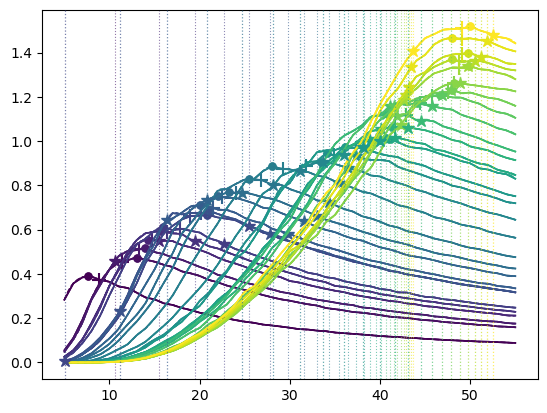

In [7]:
# --- параметры линейного фита из твоего графика (Tmax vs 1/L^2)
A_FIT = -1.93e4
B_FIT =  64.6
USE_MODE = "invL2"   # именно 1/L^2

def Tproj_from_fit(L):
    x = (1.0/L)**2 if USE_MODE == "invL2" else (1.0/L)
    return A_FIT*x + B_FIT

# ... после того как получены spl для каждого L ...
for i, e in enumerate(entries[2:]):
    L   = int(e["L"])
    T   = np.array(e["T_grid"], float)
    chi = np.array(e["Chi_T"],  float)

    Tpk, chimax, (TT, YY), spl = refined_peak_spline(T, chi, s=0.0, k=3, ngrid=2001)
    color = cmap(i)

    # исходные кривые
    plt.plot(T, chi, '-', lw=1.2, color=color, label=f"L={L}")
    plt.plot(TT, YY, '--', lw=1.0, color=color, alpha=0.9)
    plt.plot([Tpk], [float(spl(Tpk))], 'o', ms=5, color=color)

    # проекция из линейного фита
    Tproj = float(Tproj_from_fit(L))
    # рисуем только если попадаем в диапазон T этого L
    if T.min() <= Tproj <= T.max():
        chiproj = float(spl(Tproj))
        plt.plot([Tproj], [chiproj], marker='*', ms=9, color=color, zorder=5)
        plt.axvline(Tproj, color=color, ls=':', lw=0.9, alpha=0.7, zorder=4)
    # иначе — пропускаем, чтобы не было «нестыковок»

# после цикла:
print("Using fixed linear fit Tmax = A*(1/L^2) + B with A,B =", A_FIT, B_FIT)

# --- настройки
USE_MODE = "invL2"      # фиксируем 1/L^2
SKIP_FIRST = 2          # как у тебя
LOCAL_K = 5             # локальный фит по 5 ближайшим L (нечётное: 3/5/7)

# 1) собери те же L, что рисуешь
Ls_draw = np.array([int(e["L"]) for e in entries[SKIP_FIRST:]], int)

# 2) найдём T_max(L) сплайном для этих же L
Tmax = []
splines = {}
for e in entries[SKIP_FIRST:]:
    L = int(e["L"])
    T = np.array(e["T_grid"], float)
    chi = np.array(e["Chi_T"],  float)
    Tpk, _, (TT, YY), spl = refined_peak_spline(T, chi, s=0.0, k=3, ngrid=2001)
    Tmax.append(Tpk)
    splines[L] = (T, chi, TT, YY, spl)
Tmax = np.array(Tmax, float)

x = (1.0/Ls_draw) if USE_MODE=="invL" else (1.0/Ls_draw)**2

# 3a) ГЛОБАЛЬНЫЙ фит
Aglob, Bglob = np.polyfit(x, Tmax, 1)

# 3b) ЛОКАЛЬНЫЙ фит (robust к кривизне)
def local_proj(Li):
    # найти K ближайших по L
    d = np.abs(Ls_draw - Li)
    idx = np.argsort(d)[:LOCAL_K]
    xi, yi = x[idx], Tmax[idx]
    a, b = np.polyfit(xi, yi, 1)
    xL = (1.0/Li) if USE_MODE=="invL" else (1.0/Li)**2
    return a*xL + b  # T_proj локально

# 4) рисуем: реальная χ(T), истинный пик (кружок), глобальная проекция (звезда), локальная (+)
for i, L in enumerate(Ls_draw):
    T, chi, TT, YY, spl = splines[L]
    color = cmap(i)

    plt.plot(T, chi, '-', lw=1.2, color=color, label=None)
    plt.plot(TT, YY, '--', lw=1.0, color=color, alpha=0.9)

    # истинный пик
    plt.plot([Tmax[i]], [float(spl(Tmax[i]))], 'o', ms=5, color=color)

    # глобальная проекция
    xL = (1.0/L) if USE_MODE=="invL" else (1.0/L)**2
    Tproj_g = Aglob*xL + Bglob
    if T.min() <= Tproj_g <= T.max():
        plt.plot([Tproj_g], [float(spl(Tproj_g))], marker='*', ms=9, color=color)
        plt.axvline(Tproj_g, color=color, ls=':', lw=0.8, alpha=0.6)

    # локальная проекция
    Tproj_l = local_proj(L)
    if T.min() <= Tproj_l <= T.max():
        plt.plot([Tproj_l], [float(spl(Tproj_l))], marker='+', ms=10, mew=1.5, color=color)

print(f"GLOBAL fit (Tmax vs 1/L^2): y = {Aglob:.3g} x + {Bglob:.3g} (Tc≈{Bglob:.3g})")


/tmp/ipykernel_40478/2839197294.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(Ls))


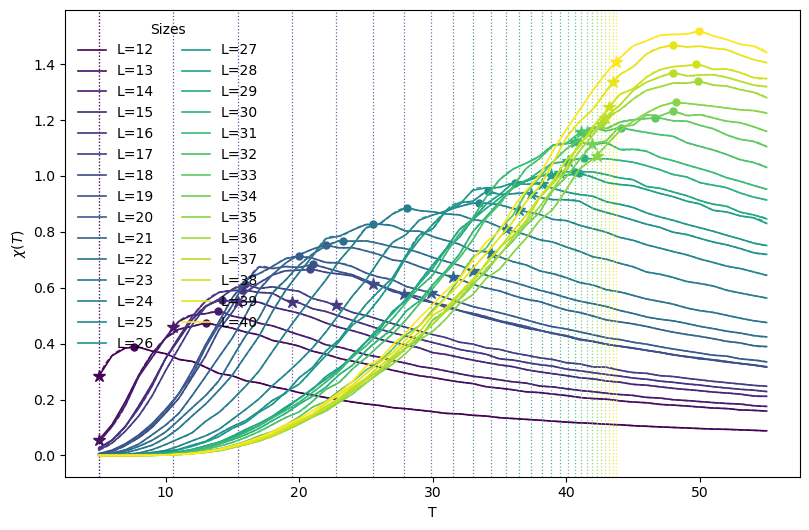

Linear fit for T_max vs 1/L^2:  y = -7.4e+03 * x + 48.3  (intercept ~ Tc)
L= 12  T_peak=7.62500   T_proj=-3.03688
L= 13  T_peak=13.05000   T_proj=4.56122
L= 14  T_peak=13.90000   T_proj=10.59007
L= 15  T_peak=14.25000   T_proj=15.45385
L= 16  T_peak=15.70000   T_proj=19.43449
L= 17  T_peak=15.92500   T_proj=22.73355
L= 18  T_peak=20.82500   T_proj=25.49819
L= 19  T_peak=21.05000   T_proj=27.83791
L= 20  T_peak=20.00000   T_proj=29.83553
L= 21  T_peak=22.00000   T_proj=31.55462
L= 22  T_peak=23.25000   T_proj=33.04466
L= 23  T_peak=25.50000   T_proj=34.34461
L= 24  T_peak=28.05000   T_proj=35.48547
L= 25  T_peak=33.47500   T_proj=36.49219
L= 26  T_peak=34.17500   T_proj=37.38499
L= 27  T_peak=36.15000   T_proj=38.18045
L= 28  T_peak=40.95000   T_proj=38.89221
L= 29  T_peak=40.62500   T_proj=39.53161
L= 30  T_peak=41.30000   T_proj=40.10815
L= 31  T_peak=40.90000   T_proj=40.62980
L= 32  T_peak=44.10000   T_proj=41.10331
L= 33  T_peak=46.67500   T_proj=41.53443
L= 34  T_peak=48.02500   T

In [2]:
import json, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import UnivariateSpline

INFILE = "peak_convergence.json"
USE_MODE = "invL2"   # "invL2" или "invL"

def refined_peak_spline(T, chi, s=0.0, k=3, ngrid=4001):
    T = np.asarray(T, float); chi = np.asarray(chi, float)
    m = np.isfinite(T) & np.isfinite(chi); T, chi = T[m], chi[m]
    i = np.argsort(T); T, chi = T[i], chi[i]
    if len(T) < k+1:
        j = int(np.argmax(chi)); return float(T[j]), float(chi[j]), (T, chi), None
    spl = UnivariateSpline(T, chi, s=s, k=k)
    TT  = np.linspace(T.min(), T.max(), ngrid)
    YY  = spl(TT)
    j   = int(np.argmax(YY))
    return float(TT[j]), float(YY[j]), (TT, YY), spl

# --- загрузка
with open(INFILE, "r") as f:
    data = json.load(f)
entries = sorted(data["entries"], key=lambda e: e["L"])

# --- собираем пики для фита T_max(L)
Ls, Tpeaks, SplineObjs = [], [], {}
summ = []

for e in entries[2:]:  # как у тебя — пропускаем первые 2 размера
    L   = int(e["L"])
    T   = np.array(e["T_grid"], float)
    chi = np.array(e["Chi_T"],  float)
    Tpk, chimax, (TT, YY), spl = refined_peak_spline(T, chi, s=0.0, k=3, ngrid=2001)
    Ls.append(L); Tpeaks.append(Tpk)
    SplineObjs[L] = (T, chi, TT, YY, spl)   # чтобы интерполировать chi в произвольном T
    summ.append((L, Tpk, chimax))

Ls      = np.array(Ls, int)
Tpeaks  = np.array(Tpeaks, float)
xscale  = (1.0/Ls) if USE_MODE=="invL" else (1.0/Ls)**2

# --- линейный фит T_max = a*x + b
coef = np.polyfit(xscale, Tpeaks, 1)  # [a, b]
a, b = float(coef[0]), float(coef[1])

# --- построение χ(T) + проекции
plt.figure(figsize=(8.2, 5.4))
cmap = cm.get_cmap("viridis", len(Ls))

for i, L in enumerate(Ls):
    T, chi, TT, YY, spl = SplineObjs[L]
    color = cmap(i)

    # исходные данные и сплайн
    plt.plot(T, chi, '-', lw=1.2, color=color, label=f"L={L}")
    plt.plot(TT, YY, '--', lw=1.0, color=color, alpha=0.9)

    # настоящий пик (с кружком)
    Tpk = Tpeaks[i]
    chipk = float(spl(Tpk))
    plt.plot([Tpk], [chipk], 'o', ms=5, color=color)

    # предсказанный по линейному фиту "Tc(L)"
    xL   = (1.0/L) if USE_MODE=="invL" else (1.0/L)**2
    Tproj = a*xL + b
    # ограничим в пределах диапазона T, чтобы не выйти за сплайн
    Tproj = float(np.clip(Tproj, T.min(), T.max()))
    chiproj = float(spl(Tproj))
    # звезда в точке проекции
    plt.plot([Tproj], [chiproj], marker='*', ms=9, color=color)
    # вертикальная пунктирная линия
    plt.axvline(Tproj, color=color, ls=':', lw=0.9, alpha=0.8)

plt.xlabel("T"); plt.ylabel(r"$\chi(T)$")
plt.legend(title="Sizes", frameon=False, ncol=2)
plt.tight_layout(); plt.show()

# --- служебный вывод
mode_txt = "1/L" if USE_MODE=="invL" else "1/L^2"
print(f"Linear fit for T_max vs {mode_txt}:  y = {a:.3g} * x + {b:.3g}  (intercept ~ Tc)")
for L, Tpk, chimax in summ:
    xL = (1.0/L) if USE_MODE=="invL" else (1.0/L)**2
    Tproj = a*xL + b
    print(f"L={L:>3}  T_peak={Tpk:.5f}   T_proj={Tproj:.5f}")


In [60]:
entries

[{'L': 10,
  'N': 2,
  'T_peak': 5.0,
  'chi_max': 0.14928000000000008,
  'chi_err_at_peak': 0.003856333263606765,
  'acceptance_rate_lastT': 0.0,
  'T_grid': [5.0,
   6.0,
   7.0,
   8.0,
   9.0,
   10.0,
   11.0,
   12.0,
   13.0,
   14.0,
   15.0,
   16.0,
   17.0,
   18.0,
   19.0,
   20.0,
   21.0,
   22.0,
   23.0,
   24.0,
   25.0,
   26.0,
   27.0,
   28.0,
   29.0,
   30.0,
   31.0,
   32.0,
   33.0,
   34.0,
   35.0,
   36.0,
   37.0,
   38.0,
   39.0,
   40.0,
   41.0,
   42.0,
   43.0,
   44.0,
   45.0,
   46.0,
   47.0,
   48.0,
   49.0,
   50.0,
   51.0,
   52.0,
   53.0,
   54.0,
   55.0],
  'Chi_T': [0.14928000000000002,
   0.12926666666666664,
   0.11622857142857142,
   0.10455,
   0.09515555555555555,
   0.08668,
   0.08047272727272728,
   0.074,
   0.06910769230769231,
   0.06514285714285713,
   0.06072,
   0.05665,
   0.0544,
   0.05122222222222222,
   0.04892631578947368,
   0.04686,
   0.04459047619047619,
   0.04276363636363637,
   0.04104347826086956,
   0.03935

In [9]:

INFILE = "peak_convergence.json"

with open(INFILE, "r") as f:
    data = json.load(f)
entries = sorted(data["entries"], key=lambda e: e["L"])


/tmp/ipykernel_12054/2315937139.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(entries))


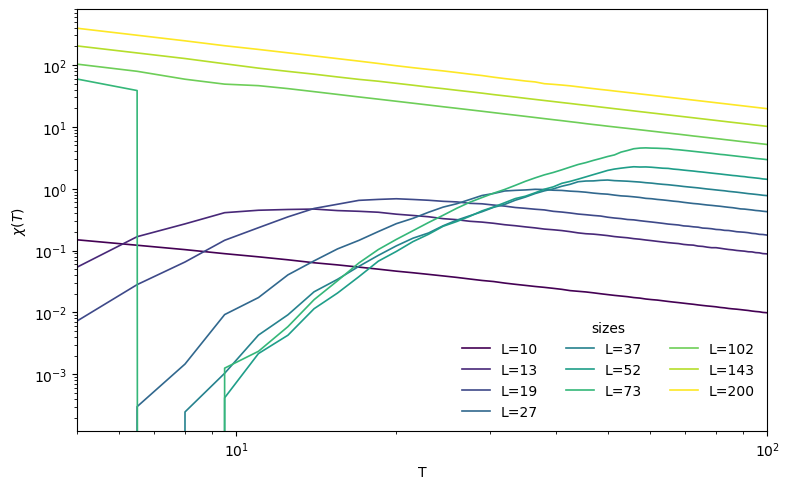

In [ ]:
import json, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

INFILE = "peak_convergence_log.json"

with open(INFILE, "r") as f:
    data = json.load(f)
entries = sorted(data["entries"], key=lambda e: e["L"])#[1:7]

chi_array = []
T_array = []
L_array = []


entries = entries[]

plt.figure(figsize=(8,5))
cmap = cm.get_cmap("viridis", len(entries))


for i, e in enumerate(entries):
    L   = e["L"]
    T   = np.array(e["T_grid"], float)
    chi = np.array(e["Chi_T"],  float)
    T_array.append(T)
    L_array.append(L)
    chi_array.append(chi)
    color = cmap(i)
    plt.plot(T, chi, '-', lw=1.2, color=color, label=f"L={L}")
    # jmax = np.argmax(chi)
    # Tmax, chimax = T[jmax], chi[jmax]
    # summary.append((L, Tmax, chimax))
    # plt.plot(Tmax, chimax, 'o', ms=5, color=color)

plt.xlabel("T")
# plt.ylim(0,4.75)
plt.xscale('log')
plt.yscale('log')
plt.xlim(5,100)
plt.ylabel(r"$\chi(T)$")
plt.legend(title="sizes", frameon=False, ncol=3)
plt.tight_layout()
plt.show()


/tmp/ipykernel_12054/4161121894.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(entries))


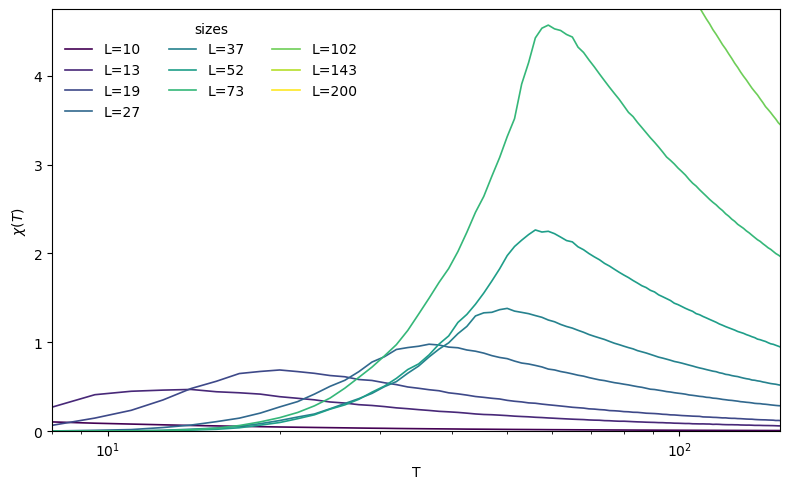

In [6]:
import json, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

INFILE = "peak_convergence_log.json"

with open(INFILE, "r") as f:
    data = json.load(f)
entries = sorted(data["entries"], key=lambda e: e["L"])#[1:7]

chi_array = []
T_array = []
L_array = []

plt.figure(figsize=(8,5))
cmap = cm.get_cmap("viridis", len(entries))


for i, e in enumerate(entries):
    L   = e["L"]
    T   = np.array(e["T_grid"], float)
    chi = np.array(e["Chi_T"],  float)
    T_array.append(T)
    L_array.append(L)
    chi_array.append(chi)
    color = cmap(i)
    plt.plot(T, chi, '-', lw=1.2, color=color, label=f"L={L}")
    # jmax = np.argmax(chi)
    # Tmax, chimax = T[jmax], chi[jmax]
    # summary.append((L, Tmax, chimax))
    # plt.plot(Tmax, chimax, 'o', ms=5, color=color)

plt.xlabel("T")
plt.ylim(0,4.75)
plt.xscale('log')
# plt.yscale('log')
plt.xlim(8,150)
plt.ylabel(r"$\chi(T)$")
plt.legend(title="sizes", frameon=False, ncol=3)
plt.tight_layout()
plt.show()


In [59]:
print(np.array(chi_array).shape)

(6, 101)


In [60]:
chi_array = np.array(chi_array)[:,8:]
L_array = np.array(L_array)
T_array = np.array(T_array)[:,8:]

In [56]:
T_array.shape

(0, 93)

In [34]:
from scipy.interpolate import interp1d

def error(param):
    gamma, nu, Tc = param
    L_min=np.min(L_array)

    y = chi_array * L_array[:,None] ** (- gamma/nu)
    x = (T_array - Tc)/Tc * L_array[:,None] ** (1.0/ nu)

    x_grid = (T_array[0] - Tc)/Tc * L_min** (1.0/ nu)
    # print(x.min(),x.max(),x_grid.min(),x_grid.max())
    func=[]
    for x_,y_ in zip(x,y):
        func.append(interp1d(x_,y_,fill_value=0)(x_grid))

    return np.sum(np.std(func,axis=1))

from scipy.optimize import minimize

res=minimize(error,x0=(7/4,1,10)) #, bounds=[(0, 3), (0, 3), (10, 100)])


TypeError: list indices must be integers or slices, not tuple

In [43]:
res['x']

array([ 2.04434493,  0.38023434, 10.00037202])

In [44]:
gamma_array = np.linspace(0.25,5,10)
nu_array = np.linspace(0.25,5,10)
Tc_array = np.linspace(10,30,10)

Bestt (coarse) → gamma=2.2, nu=0.6, Tc=55, cost=0.00343608
Best (refined) → gamma=2.5, nu=0.3, Tc=55, cost=2.59191e-08

In [73]:
Tc = 15

gamma = 5/4
nu = 1.2


# gamma, nu, Tc = res['x']



y = chi_array * L_array[:,None] ** (- gamma/nu)
x = (T_array - Tc)/Tc * L_array[:,None] ** (1.0/ nu)

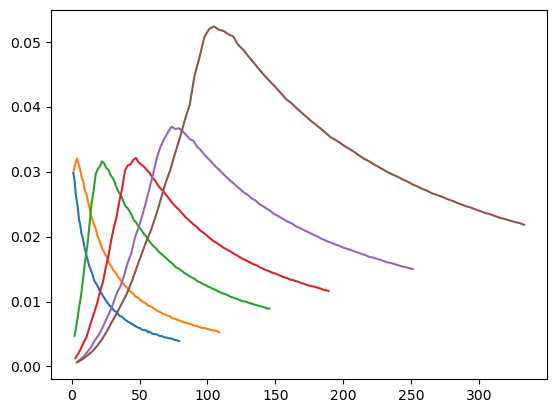

In [75]:
for x_,y_ in zip(x,y):
    plt.plot(x_,y_)#,'-o')
